# Investment Game
The rules of the investment game are outlined in the `README.md`. Here we are implementing a simple environment in order to play the game.

In [6]:
import numpy as np
import gym

## Time-series for assets

In [7]:
import seaborn as sns
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
sns.set()

In [44]:
# parameter
std_dev_noise = 0.0
x_max = 5
y_min, y_max = [1, 4]
num_nodes = 2
x_range = np.arange(1, x_max-1)
values = np.arange(y_min, y_max)

In [49]:
x = np.sort(np.append(np.random.choice(x_range, num_nodes, replace=False), np.array([0, x_max-1])))
y = np.random.choice(values, num_nodes+2, replace=True)
f = interpolate.interp1d(x, y, kind='linear', bounds_error=False)

x_interpolated = np.arange(x_max)
noise = np.random.normal(0, std_dev_noise, len(x_interpolated))
signal = f(x_interpolated) + noise
df = pd.DataFrame({'round': x_interpolated, 'price': signal})


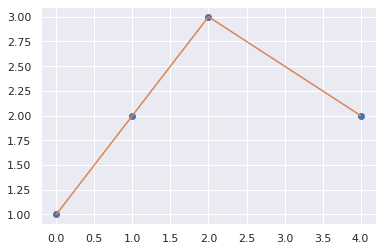

In [50]:
plt.plot(x, y, 'o', x_interpolated, signal, '-')

<AxesSubplot:xlabel='round', ylabel='price'>

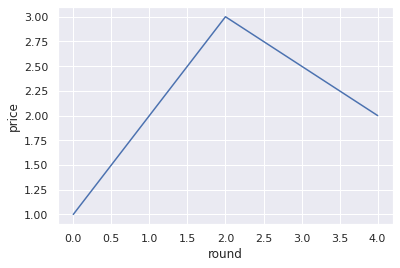

In [51]:
sns.lineplot(data=df, x='round', y='price')

In [146]:
df['pct_change'] = df['price'].pct_change()


In [147]:
# save asset price to disk
import os
prefix = 'resources/data/'
os.makedirs(prefix, exist_ok=True)
file_name = os.path.join(prefix, 'asset.csv')
df.to_csv(file_name, index=False)

## Game environment

In [159]:
class InvestmentGameSimple(gym.Env):
    def __init__(self):
        self.num_rounds = 5
        self.initial_balance = 10
        self.asset = pd.read_csv(file_name)
        self.action_space = ['buy', 'sell', 'hold'] # depending on state
        self.state_space = [True, False]
        
    def is_terminal(self, state):
        round = state[0]
        if round >= self.num_rounds:
            return True
        else:
            return False
        
    def reset(self):
        self.round = 0
        self.invested = False
        self.balance = self.initial_balance
        return (self.round, self.balance, self.invested)
    
    def get_next_state_and_reward(self, state, action):
        # business logic
        round, balance, invested = state
        result = dict()
        if action == 'buy':
            result['invested_in_next_step'] = True
        elif action == 'sell':
            result['invested_in_next_step'] = False
        elif action == 'hold':
            result['invested_in_next_step'] = invested
        result['next_round'] = round + 1
        
        if invested:
            result['absolute_change_of_balance'] = self.get_pct_change_for_round(
                round) * balance
        else:
            result['absolute_change_of_balance'] = 0
        
        result['next_balance'] = balance + result['absolute_change_of_balance']
        result['reward'] = result['absolute_change_of_balance']
        return result

    
    def step(self, action):
        result = self.get_next_state_and_reward(
            state=(self.round, self.balance, self.invested),
            action=action
            )
        self.round = result['next_round']
        self.balance = result['next_balance']
        self.invested = result['invested_in_next_step']
        state = (self.round, self.balance, self.invested)
        reward = result['reward']
        done = self.is_terminal(state)
        info = {'balance': self.balance}
        return state, reward, done, info
        
    def get_price_for_round(self, round):
        return self.asset.set_index('round').loc[round, 'price']
    
    def get_pct_change_for_round(self, round):
        return self.asset.set_index('round').loc[round, 'pct_change']


In [160]:
investmentGame = InvestmentGameSimple()

In [197]:
investmentGame.reset()
done = False
while not done:
    action = np.random.choice(investmentGame.action_space)
    print(action)
    state, reward, done, info = investmentGame.step(action)
    print(info)

hold
{'balance': 10}
hold
{'balance': 10}
hold
{'balance': 10}
hold
{'balance': 10}
sell
{'balance': 10}
